In [0]:
include __DIR__ . '/vendor/autoload.php';

use Gregwar\GnuPlot\GnuPlot;
use Rubix\ML\Regressors\SVR;
use Rubix\ML\Kernels\SVM\RBF;
use Rubix\ML\Datasets\Labeled;
use Rubix\ML\Datasets\Unlabeled;
use Rubix\ML\Transformers\MinMaxNormalizer;


<div>
<p>
This is a (partial) PHP adaptation of this <a href="https://github.com/DrDub/riiaa20_ws25_feateng_space_time/blob/master/notebooks/2_Temporal_Time_Series-from-workshop.ipynb">Python notebook presented at a workshop in RIIAA'20</a>. The notebook in turn is adapted from Chapter 7 of <a href="http://artoffeatureengineering.com/">The Art of Feature Engineering</a>. The cell numbers in the comments track back to the <a href="http://artoffeatureengineering.com/notebooks/Chapter7.html">case study</a> in that chapter.
</p>
<p>
This code distributed under MIT license.
</p>
</div>


<div>
<h1>Handling Time Series using Target Lags</h1>

<p>This is a small datasets for country-level population prediction based on historical data.</p>
<p>We want to predict the population of a given country in a given year. Note that there are very few countries in the world, as such we will use few features to avoid having many more parameters than training data.</p>
<p>In fact, besides the population data, we will only use two other features: the number of in links and out links for the country Wikipedia page. The idea being that larger countries might have larger Wikipedia pages (resulting in more out links) and have more Wikipedia related to them (resulting in a larger number of in links).</p>
<p>Let us start by identifying all entities of type <a href="http://dbpedia.org/ontology/Country">http://dbpedia.org/ontology/Country</a> (Cell #18).</p>
</div>


In [1]:
// from CELL 23
$rels = array();
$tsv = explode("\n", file_get_contents("ch7_cell22_rels_in_out.tsv"));
array_pop($tsv); // last
array_shift($tsv); // header
foreach($tsv as $line) {
   $parts = explode("\t", $line);
   $country = $parts[0];
   $rels_out = $parts[1];
   $rels_in = $parts[2];
   $rels[$country] = [ intval($rels_out), intval($rels_in) ];
}

$mapping = array();
$m = explode("\n", file_get_contents("ch7_cell21_wb_uri_mapping.tsv"));
array_pop($m); // last
foreach($m as $line) {
  $parts = explode("\t", $line);
  $wb = $parts[0];
  $db = $parts[1];
  //echo "$wb ". htmlspecialchars($db). "<br>";
  $mapping[$wb] = $db;
}

$data = [];
$wb = explode("\n", file_get_contents("ch7_cell19_wb_pop.tsv"));
echo "wb_pop has " . count($wb) . " lines<br>";
$line = array_shift($wb); // header
$header = explode("\t", $line);
array_splice($header, 1, 0, ["rels_out", "rels_in"]);
foreach($wb as $line) {
  $fields = explode("\t", $line);
  $wb_country = array_shift($fields);
  if(! isset($mapping[$wb_country])) {
     continue;
  }
  while($fields[count($fields)-1] == '') {
     array_pop($fields);
  }
  $db_country = $mapping[$wb_country];
  $tuple = [];
  $tuple[] = $rels[$db_country][0];
  $tuple[] = $rels[$db_country][1];
  foreach($fields as $field) { 
     if($field) {
        $tuple[] = intval($field);
     }else{
        $tuple[] = 0;
     }
  }
  $data[] = [ $wb_country, $tuple ];
}
echo "Data for " . count($data) . " countries\n";


wb_pop has 266 lines Data for 217 countries

In [2]:
// save all data
$tsv = [];
$tsv[] = implode("\t", $header);
foreach($data as $pair) {
  $line = $pair[0];
  foreach($pair[1] as $point) {
     $line .= "\t" . $point;
  }
  $tsv[] = $line;
}
file_put_contents("cell23_countries_data.tsv", implode("\n", $tsv)."\n");

// split train and final test
mt_srand(42);

// Fisher-Yates shuffle as PHP shuffle is self-seeded
function fy_shuffle(&$arr) {
  for ($i = count($arr) - 1; $i > 0; $i--) {
    $j = mt_rand(0, $i);
    $tmp = $arr[$i];
    $arr[$i] = $arr[$j];
    $arr[$j] = $tmp;
  }
}
fy_shuffle($data);
$pivot = intval(count($data) * 0.8);
$devset = array_slice($data, 0, $pivot);
$heldout = array_slice($data, $pivot);
$tsv = [];
$tsv[] = implode("\t", $header);
foreach($devset as $pair) {
  $line = $pair[0];
  foreach($pair[1] as $point) {
     $line .= "\t" . $point;
  }
  $tsv[] = $line;
}
file_put_contents("cell23_countries_dev.tsv", implode("\n", $tsv)."\n");

$tsv = [];
$tsv[] = implode("\t", $header);
foreach($heldout as $pair) {
  $line = $pair[0];
  foreach($pair[1] as $point) {
     $line .= "\t" . $point;
  }
  $tsv[] = $line;
}
file_put_contents("cell23_countries_held.tsv", implode("\n", $tsv)."\n");

echo "<br>Devset size:  " . count($devset);
echo "<br>Heldout size: " . count($heldout);



Devset size: 173 Heldout size: 44

<div>
<p>With the data split properly, we can start some EDA on it.</p>

<h2>EDA</h2>

<p>Let's plot the relations and current population to see if there is a correlation (Cell #24).</p>

</div>


In [3]:
// from CELL 24

$pops = [];
$num_in_rels = [];
$num_out_rels = [];
foreach($devset as $pair) {
  $fields = $pair[1];
  $pop = floatval($fields[count($fields)- 1]);
  $out_rels = floatval($fields[1]);
  $in_rels = floatval($fields[2]);
  if($out_rels == 0){
     continue;
  }
  $pops[] = log($pop, 10);
  $num_out_rels[] = log($out_rels, 10);
  $num_in_rels[] = log($in_rels, 10);
}




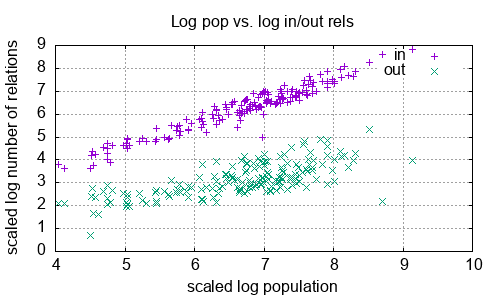

In [4]:
class MyPlot extends GnuPlot {
    protected $stub = true;
    protected $verbose = false;
    public function __construct() {
        parent::__construct();
        $this->mode = 'points';
    }
    public function setMode($mode) {
        $this->mode = $mode;
    }
    public function setStub($stub) {
        $this->stub = $stub;
    }
    public function setVerbose($verbose) {
        $this->verbose = $verbose;
    }
    public function sendCommand($command): void {
        if($this->verbose){
            echo "$command\n<br>\n";
        }
        parent::sendCommand($command);
    }
    public function get($format = self::TERMINAL_PNG) {
        if($this->stub) {
            return "";
        }
        $this->sendInit();
        $this->sendCommand("set terminal $format size {$this->width}{$this->unit}, {$this->height}{$this->unit}");
        fflush($this->stdout);
        $this->plot();

        // Reading data, timeout=500ms
        $result = '';
        $timeout = 1000;
        do {
            stream_set_blocking($this->stdout, false);
            $data = fread($this->stdout, 128);
            $result .= $data;
            usleep(20000);
            $timeout -= 5;
        } while ($timeout > 0 || $data);

        return $result;
    }
}
$plot = new MyPlot;
$plot->setStub(false);

$plot
  ->setGraphTitle('Log pop vs. log in/out rels')
  ->setXLabel('scaled log population')
  ->setYLabel('scaled log number of relations')
  ->setWidth(500)
  ->setHeight(300);
$plot->setTitle(0, 'in');
for($idx=0; $idx<count($pops); $idx++) {
  $plot->push($pops[$idx], $num_in_rels[$idx]);
}
$plot->setTitle(1, 'out');
for($idx=0; $idx<count($pops); $idx++) {
  $plot->push($pops[$idx], $num_out_rels[$idx], 1);
}
//$plot->display();
$png = $plot->get();
$base64 = 'data:image/png;base64,' . base64_encode($png);

echo "<img src='$base64'/>";




<div>
<p>From the figure we can see that the number of in relations is informative, but the number of out relations is not, most of the countries are involved in the same number of standard relations.</p>

<p>Let us now take 10 random countries and look at their time series data (Cell #25).</p>
</div>


,
,
,
,
,
,

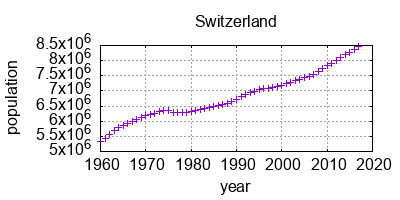
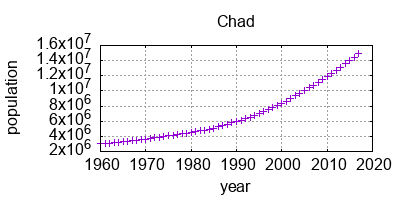
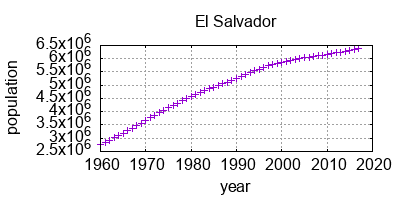
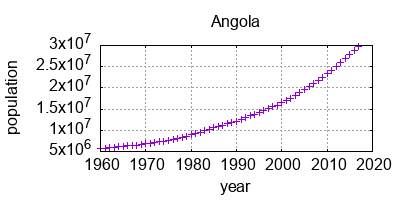
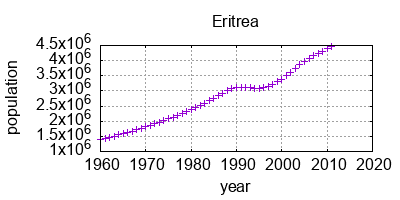
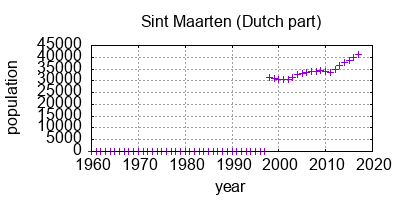
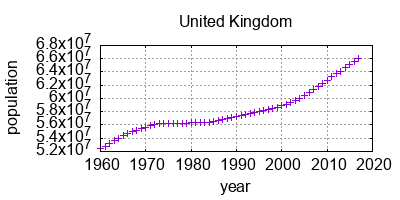
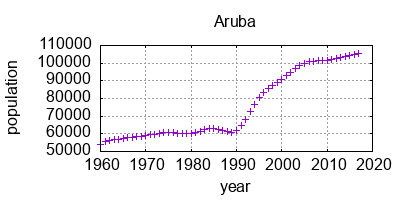
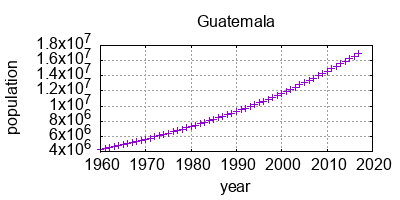
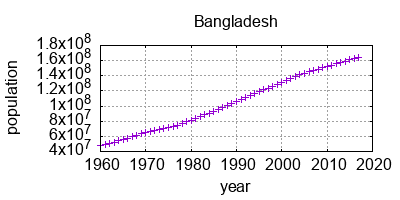
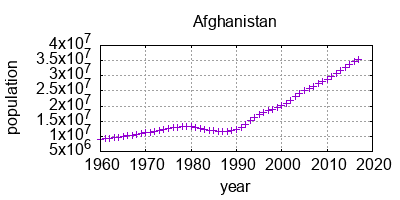
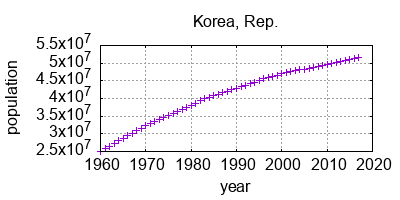

In [5]:
// from CELL 25

$indices = [];
for($idx=0; $idx<count($devset); $idx++){
  $indices[]=$idx;
}
mt_srand(42);
fy_shuffle($indices);
$to_show=[];

$years=[];
for($idx=3;$idx<count($header); $idx++){
  $years[]= intval($header[$idx]);
}

echo '<table>';

for($idx=0;$idx<12; $idx++){
  $pair=$devset[$indices[$idx]];
  if($idx % 2 == 0) { 
    echo '<tr>';
  }
  $plot->flush();
  $plot
    ->setGraphTitle($pair[0])
    ->setXLabel('year')
    ->setYLabel('population')
    ->setWidth(400)
    ->setHeight(200)
    ->setTitle(0, "");
   for($idx2=2; $idx2<count($pair[1]); $idx2++) {
     $plot->push($years[$idx2-2], $pair[1][$idx2]);
   }
   $png = $plot->get();
   $base64 = 'data:image/png;base64,' . base64_encode($png);

   echo "<td><img src='$base64'/></td>";
   if($idx % 2 == 1) {
      echo '</tr>'."\n";
   }
}
echo '</table>'."\n";





<div>
<p>In the figure we can see trend reversal, missing data (Sint Maarten) and a variety of curves.
</p>
</div>


<div>
<h1>No TS data</h1>
<p>
Let us start by using only the number of relations (Cell #33) and the year.
</p>
</div>


In [6]:
// from CELL 33

mt_srand(42);
$train_data = [];
$dev_data   = [];
$test_data  = [];
$full_header = $header;
$header = [ $full_header[0], "log_" . $full_header[1], "log_" . $full_header[2], "year", "logpop_year" ];
foreach($devset as $pair) {
   $name = $pair[0];
   $feats = $pair[1];
   $out_rels = floatval($feats[0]);
   $in_rels  = floatval($feats[1]);
   if($out_rels == 0){
     $out_rels = 1.0;
   }
   $isTest = (mt_rand() * 1.0 / mt_getrandmax()) < 0.2;
   $isDev  = (mt_rand() * 1.0 / mt_getrandmax()) < 0.1;
   // start from +10 years to accommodate lag-10 later on
   for($year_idx = 2 + 10; $year_idx < count($feats); $year_idx++) {
      $pop = floatval($feats[$year_idx]);
      if(! $pop){ // missing data? skip
         continue;
      }
      if(! $fields[$year_idx - 10]) { // missing lag data? skip
         continue;
      }
      $row = [ [ log($out_rels, 10), log($in_rels, 10), floatval($full_header[$year_idx + 1]) ], 
                   log($pop, 10), $name ];
      if($isTest) {
        $test_data[] = $row;
      }elseif($isDev){
        $dev_data[] = $row;
      }else{
        $train_data[] = $row;
      }
   }
}
echo "Train data size: " . count($train_data) . "<br>";
echo "Dev data size: " . count($dev_data) . "<br>";
echo "Test data size: " . count($test_data) . "<br>";

$tsv=[];
foreach($train_data as $row) {
  $tsv[] = implode("\t", [ $row[2], implode("\t", $row[0]), $row[1] ]);
}
foreach($test_data as $row) {
  $tsv[] = implode("\t", [ $row[2], implode("\t", $row[0]), $row[1] ]);
}
file_put_contents("cell33_feat1.tsv", implode("\n", $tsv)."\n");

function keycmp($a, $b) {
    if ($a[1] == $b[1]) {
        return 0;
    }
    return ($a[1] < $b[1]) ? -1 : 1;
}
usort($test_data, "keycmp");
$test_names = [];
foreach($test_data as $row) {
  $test_names[] = $row[2];
}


Train data size: 5774 Dev data size: 480 Test data size: 2013

In [7]:
$xtrain = []; $ytrain = [];
$xdev   = []; $ydev   = [];
$xtest  = []; $ytest  = [];
foreach($train_data as $row){
  $xtrain[] = $row[0]; $ytrain[] = $row[1];
}
foreach($dev_data as $row){
  $xdev[] = $row[0]; $ydev[] = $row[1];
}
foreach($test_data as $row){
  $xtest[] = $row[0]; $ytest[] = $row[1];
}
$trainds = new Labeled($xtrain, $ytrain);
$devds   = new Unlabeled($xdev);
$testds  = new Unlabeled($xtest);




In [8]:
// targets need to be normalized separately
$target_scaler = new MinMaxNormalizer(0.0, 1.0);

function targetToSamples($arr) {
  $res=[];
  foreach($arr as $val) {
    $res[] = [$val];
  }
  return $res;
}
function samplesToTarget($arr) {
  $res=[];
  foreach($arr as $vval) {
    $res[] = $vval[0];
  }
  return $res;
}          
$ytrain_orig = $ytrain;
$tmp = new Unlabeled(targetToSamples($ytrain));
$target_scaler->fit($tmp);
$tmp->apply($target_scaler); $ytrain = samplesToTarget($tmp->samples());

$ydev_orig = $ydev;
$tmp = new Unlabeled(targetToSamples($ydev));
$tmp->apply($target_scaler); $ydev = samplesToTarget($tmp->samples());

$ytest_orig = $ytest;
$tmp = new Unlabeled(targetToSamples($ytest));
$tmp->apply($target_scaler); $ytest = samplesToTarget($tmp->samples());

$trainds = new Labeled($xtrain, $ytrain);

$scaler = new MinMaxNormalizer(0.0, 1.0);
$scaler->fit($trainds);
echo '<br>mins: ' . print_r($scaler->minimums(), TRUE).'<br>';
echo 'maxs: ' . print_r($scaler->maximums(), TRUE).'<br>';
$trainds->apply($scaler);
$devds->apply($scaler);
echo '<br>mins: ' . print_r($scaler->minimums(), TRUE).'<br>';
echo 'maxs: ' . print_r($scaler->maximums(), TRUE).'<br>';
$testds->apply($scaler);
echo '<br>mins: ' . print_r($scaler->minimums(), TRUE).'<br>';
echo 'maxs: ' . print_r($scaler->maximums(), TRUE).'<br>';


// just to make sure the datasets have been processed correctly in-place
$test_scaler = new MinMaxNormalizer(0.0, 1.0);
$test_scaler->fit($trainds);
echo '<br>mins: ' . print_r($test_scaler->minimums(), TRUE).'<br>';
echo 'maxs: ' . print_r($test_scaler->maximums(), TRUE).'<br>';

echo '<br>Sizes:<br> &nbsp; &nbsp; Train' . print_r($trainds->shape(), TRUE) . '<br>';
echo '&nbsp; &nbsp; Test' . print_r($testds->shape(), TRUE) . '<br>';
echo '&nbsp; &nbsp; Dev' . print_r($devds->shape(), TRUE) . '<br>';
                                          



mins: Array
(
 [0] => 0.30102999566398
 [1] => 1.602059991328
 [2] => 1970
)
 maxs: Array
(
 [0] => 1.7708520116421
 [1] => 5.33940373586
 [2] => 2017
)
 mins: Array
(
 [0] => 0.30102999566398
 [1] => 1.602059991328
 [2] => 1970
)
 maxs: Array
(
 [0] => 1.7708520116421
 [1] => 5.33940373586
 [2] => 2017
)
 mins: Array
(
 [0] => 0.30102999566398
 [1] => 1.602059991328
 [2] => 1970
)
 maxs: Array
(
 [0] => 1.7708520116421
 [1] => 5.33940373586
 [2] => 2017
)
 mins: Array
(
 [0] => 0
 [1] => 0
 [2] => 0
)
 maxs: Array
(
 [0] => 1
 [1] => 1
 [2] => 1
)
 Sizes:     TrainArray
(
 [0] => 5774
 [1] => 3
)
     TestArray
(
 [0] => 2013
 [1] => 3
)
     DevArray
(
 [0] => 480
 [1] => 3
)

In [9]:
echo "Training on " .count($xtrain) . " countries / years<br>";

// hyperparameter search
$best_c = 0.5;
$best_epsilon = 0.5;

function checkAllTheSame($arr){
    if($arr){
        $elem = $arr[0];
        foreach($arr as $val){
            if($val != $elem){
                return;
            }
        }
        echo '<b>ALL THE SAME!</b><br>';
    }
}

$best_rmse = 1000;
foreach([0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 50.0, 100.0] as $c) {
    $estimator = new SVR($c, 0.05, new RBF(1.0/$trainds->numfeatures()));
    $estimator->train($trainds);
    $ydev_pred = $estimator->predict($devds);
    checkAllTheSame($ydev_pred);
    $tmp = new Unlabeled(targetToSamples($ydev_pred));
    $tmp->reverseApply($target_scaler);
    $ydev_pred = samplesToTarget($tmp->samples());
    $RMSE = 0.0;
    $ydev_len = floatval(count($ydev));
    for($idx=0;$idx<$ydev_len;$idx++) {
        if($idx<5){
            echo $ydev_pred[$idx] . " " . $ydev_orig[$idx] . "<br>";
        }
       $diff = ($ydev_pred[$idx] - $ydev_orig[$idx]);
       $RMSE += $diff*$diff / $ydev_len; 
    }
    $RMSE = sqrt($RMSE);
    echo "C $c RMSE $RMSE<br><br>";
    if($RMSE < $best_rmse){
        $best_c = $c;
        $best_rmse = $RMSE;
    }
}

echo "Best C $best_c best RMSE $best_rmse <br>";

foreach([0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.0, 1.0, 10.0, 100.0] as $epsilon) {
    $estimator = new SVR($best_c, $epsilon, new RBF(1.0/$trainds->numfeatures()));
    $estimator->train($trainds);
    $ydev_pred = $estimator->predict($devds);
    checkAllTheSame($ydev_pred);
    $tmp = new Unlabeled(targetToSamples($ydev_pred));
    $tmp->reverseApply($target_scaler);
    $ydev_pred = samplesToTarget($tmp->samples());
    $RMSE = 0.0;
    $ydev_len = floatval(count($ydev));
    for($idx=0;$idx<$ydev_len;$idx++) {
        if($idx<5){
            echo $ydev_pred[$idx] . " " . $ydev_orig[$idx] . "<br>";
        }
       $diff = ($ydev_pred[$idx] - $ydev_orig[$idx]);
       $RMSE += $diff*$diff / $ydev_len; 
    }
    $RMSE = sqrt($RMSE);
    echo "epsilon $epsilon RMSE $RMSE<br><br>";
    if($RMSE < $best_rmse){
        $best_epsilon = $epsilon;
        $best_rmse = $RMSE;
    }
}
echo "Best epsilon $best_epsilon best RMSE $best_rmse <br>";

$best_c = 0.1;
$best_epsilon = 0.001;

$estimator = new SVR($best_c, $best_epsilon, new RBF(1.0/$trainds->numfeatures()));
$estimator->train($trainds);
$ytest_pred = $estimator->predict($testds);
checkAllTheSame($ytest_pred);
$tmp = new Unlabeled(targetToSamples($ytest_pred));
$tmp->reverseApply($target_scaler);
$ytest_pred = samplesToTarget($tmp->samples());
$RMSE = 0.0;
$ytest_len = floatval(count($ytest));
for($idx=0;$idx<$ytest_len;$idx++) {
   $diff = ($ytest_pred[$idx] - $ytest_orig[$idx]);
   $RMSE += $diff*$diff / $ytest_len; 
}
$RMSE = sqrt($RMSE);

echo "RMSE $RMSE<br>";



Training on 5774 countries / years 5.3113487761761 4.32766538705 5.3683253199113 4.3369797752007 5.4256800068798 4.3453933370909 5.4833606250642 4.3533968433975 5.5413144604639 4.3613689227436 C 0.01 RMSE 1.3392455381282 4.578092083081 4.32766538705 4.6683314244883 4.3369797752007 4.7579913475351 4.3453933370909 4.8469835271248 4.3533968433975 4.9352207574659 4.3613689227436 C 0.1 RMSE 1.2999206801151 4.4033620879082 4.32766538705 4.5089780259883 4.3369797752007 4.6127002222584 4.3453933370909 4.7144390652199 4.3533968433975 4.8141089912724 4.3613689227436 C 0.5 RMSE 1.2766168175863 4.4764952898332 4.32766538705 4.5887121676328 4.3369797752007 4.6982847805436 4.3453933370909 4.8051393408557 4.3533968433975 4.9092082793243 4.3613689227436 C 1 RMSE 1.2829929058468 4.4613284817135 4.32766538705 4.5809378292259 4.3369797752007 4.6972869702997 4.3453933370909 4.8103161614829 4.3533968433975 4.9199737736088 4.3613689227436 C 1.5 RMSE 1.2933140750184 4.3964541270547 4.32766538705 4.5220300196371 4.3369797752007 4.6438451963234 4.3453933370909 4.7618534902704 4.3533968433975 4.8760184912647 4.3613689227436 C 2 RMSE 1.293047383893 4.4323601068463 4.32766538705 4.5705092212534 4.3369797752007 4.7035452028536 4.3453933370909 4.8314508368277 4.3533968433975 4.9542226688793 4.3613689227436 C 5 RMSE 1.3128450513423 4.7716073320861 4.32766538705 4.9044027931161 4.3369797752007 5.0317611886963 4.3453933370909 5.1536892982659 4.3533968433975 5.2702091183774 4.3613689227436 C 10 RMSE 1.3591686338838 5.5369312066326 4.32766538705 5.6264584152138 4.3369797752007 5.7123812224268 4.3453933370909 5.7947723022186 4.3533968433975 5.873722516264 4.3613689227436 C 50 RMSE 1.7736027437967 6.4376006563311 4.32766538705 6.4920587793393 4.3369797752007 6.5445561703132 4.3453933370909 6.5951105668224 4.3533968433975 6.6437587876056 4.3613689227436 C 100 RMSE 2.1494803305105 Best C 0.5 best RMSE 1.2766168175863 4.6154776889911 4.32766538705 4.7170296136903 4.3369797752007 4.8166917005573 4.3453933370909 4.9143745229353 4.3533968433975 5.009992510482 4.3613689227436 epsilon 0.0001 RMSE 1.2647816124084 4.6002979234331 4.32766538705 4.7021560099635 4.3369797752007 4.8021185802094 4.3453933370909 4.9000960760331 4.3533968433975 4.9960028062124 4.3613689227436 epsilon 0.001 RMSE 1.2655225933215 4.5149088716081 4.32766538705 4.6195093923089 4.3369797752007 4.7221046804327 4.3453933370909 4.8226006670223 4.3533968433975 4.9209072783581 4.3613689227436 epsilon 0.01 RMSE 1.2540272815222 4.4195956066603 4.32766538705 4.5309247118569 4.3369797752007 4.6402394032667 4.3453933370909 4.7474401786411 4.3533968433975 4.8524316300149 4.3613689227436 epsilon 0.02 RMSE 1.2857592049864 4.4033620879082 4.32766538705 4.5089780259883 4.3369797752007 4.6127002222584 4.3453933370909 4.7144390652199 4.3533968433975 4.8141089912724 4.3613689227436 epsilon 0.05 RMSE 1.2766168175863 4.9585781839319 4.32766538705 5.0562730233773 4.3369797752007 5.1527023328828 4.3453933370909 5.2477775819034 4.3533968433975 5.3414127099428 4.3613689227436 epsilon 0.1 RMSE 1.3891644251314 5.2579893505857 4.32766538705 5.3391199159433 4.3369797752007 5.4209668361677 4.3453933370909 5.5034581532712 4.3533968433975 5.5865208372357 4.3613689227436 epsilon 0.2 RMSE 1.7810843023991 ALL THE SAME! 6.4463133673358 4.32766538705 6.4463133673358 4.3369797752007 6.4463133673358 4.3453933370909 6.4463133673358 4.3533968433975 6.4463133673358 4.3613689227436 epsilon 0.5 RMSE 1.1759525855534 4.6168064243753 4.32766538705 4.718339457482 4.3369797752007 4.8179899311505 4.3453933370909 4.9156684815661 4.3533968433975 5.0112895904637 4.3613689227436 epsilon 0 RMSE 1.265308091558 ALL THE SAME! 6.4463133673358 4.32766538705 6.4463133673358 4.3369797752007 6.4463133673358 4.3453933370909 6.4463133673358 4.3533968433975 6.4463133673358 4.3613689227436 epsilon 1 RMSE 1.1759525855534 ALL THE SAME! 6.4463133673358 4.32766538705 6.4463133673358 4.3369797752007 6.4463133673358 4.3453933370909 6.4463133673358 4.3533968433975 6.4463133

In [10]:

$ydev_pred = $estimator->predict($devds);
checkAllTheSame($ydev_pred);
$tmp = new Unlabeled(targetToSamples($ydev_pred));
$tmp->reverseApply($target_scaler);
$ydev_pred = samplesToTarget($tmp->samples());

$dev_analysis = [];
$tsv = [];
$tsv[] = $header;
$tsv[0][] = 'pred_logpop';
$tsv[0] = implode("\t", $tsv[0]);

for($idx=0;$idx<count($ydev); $idx++) {
  $row = $dev_data[$idx];
  $dev_analysis[] = array( 
    'country' =>  $row[2], 
    'feats' => $row[0],
    'logpop' => $row[1], 
    'pred_logpop' => $ydev_pred[$idx]
  ); 
  $tsv[] = implode("\t", [ $row[2], implode("\t", $row[0]), $row[1], $ydev_pred[$idx] ]);
}

file_put_contents("cell33_dev_results.tsv", implode("\n", $tsv)."\n");



2013
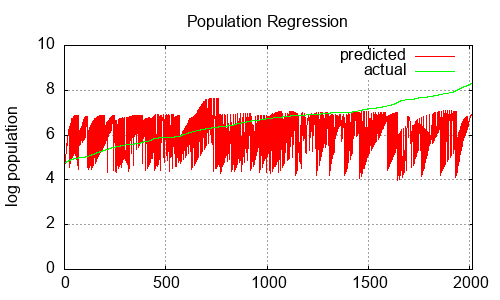

In [11]:
$plot = new MyPlot;
$plot->setStub(false);
$plot->setMode("lines");
$plot->setVerbose(false);

$plot
  ->setGraphTitle('Population Regression')
  ->setYLabel('log population')
  ->setWidth(500)
  ->setHeight(300)
  ->setXRange(0, count($test_data))
  ->setYRange(0, 10);
$plot->setTitle(0, 'predicted');
echo count($test_data)."<br>";
for($idx=0; $idx<count($test_data); $idx++) {
  $plot->push($idx, $ytest_pred[$idx]);
}

$plot->setTitle(1, 'actual');
for($idx=0; $idx<count($test_data); $idx++) {
  $plot->push($idx, $ytest_orig[$idx], 1);
}

$plot
  ->setLineColor(0, "rgb 'red'")
  ->setLineColor(1, "rgb 'green'");


//$plot->display();
$png = $plot->get();
$base64 = 'data:image/png;base64,' . base64_encode($png);

echo "<img src='$base64'/>";

